In [22]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/home/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/models
model loaded successfully!


In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [23]:
img_dir_path = '/content/images'
save_dir_path = '/content/new_images'

In [6]:
def blur_background(file, label):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()

    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 이미지 합성 후 저장
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(1199, 800, 3) (513, 342, 3) 15


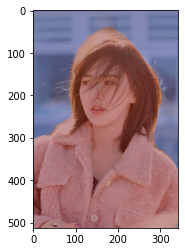

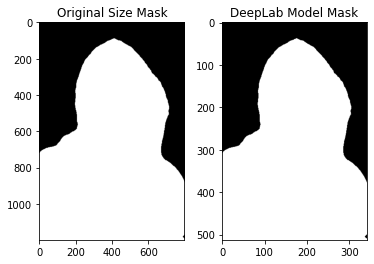

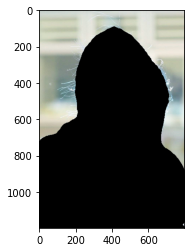

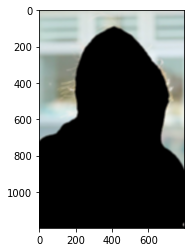

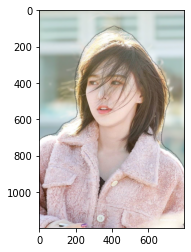

In [25]:
blur_background('my_image2.jpg', 'person')

(863, 640, 3) (513, 380, 3) 15


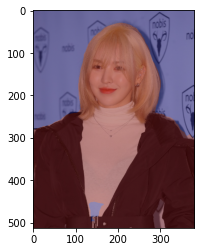

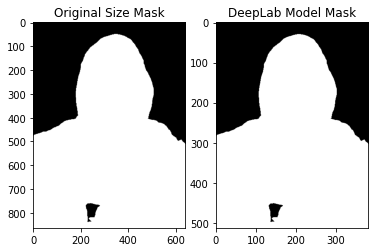

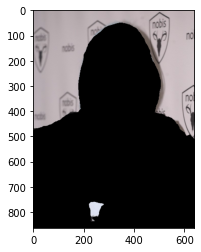

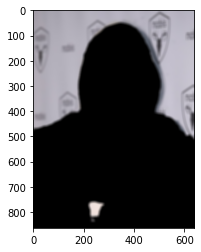

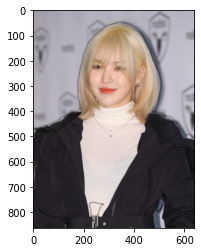

In [26]:
blur_background('my_image1.jpg', 'person')

(424, 420, 3) (513, 508, 3) 15


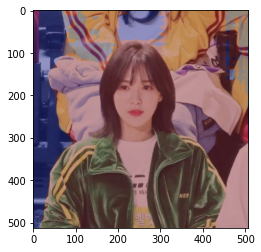

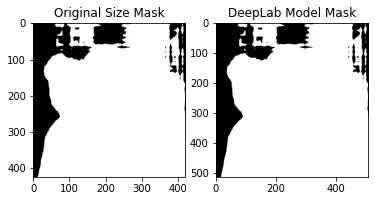

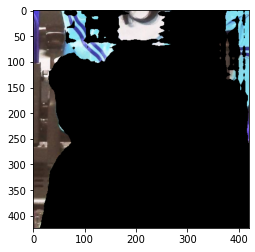

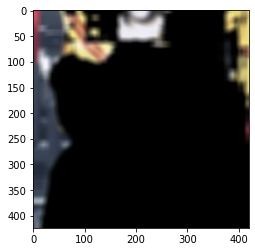

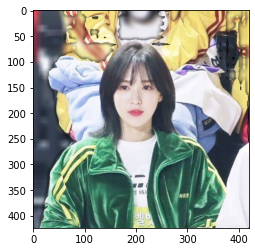

In [31]:
blur_background('my_image3.png', 'person')

In [28]:
def chroma_key(file, label, background):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir_path, background)
    bg_orig = cv2.imread(bg_path)
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
    
    # 배경과 원본 이미지 합성 후 저장
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

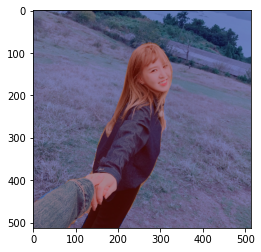

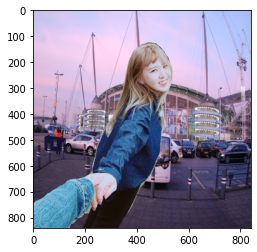

In [30]:
chroma_key('my_image4.jpg', 'person', 'my_image5.JPG')

## 문제점과 개선 방안
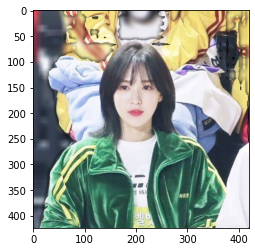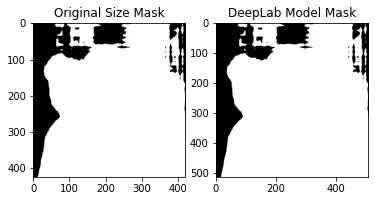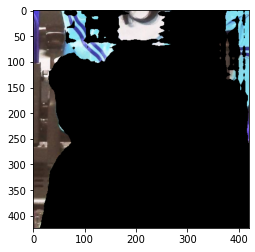
## 문제
1. 위의 이미지에서 볼 수 있듯이 사람이 아닌 다른 사물에 대해 경계선이 남는 문제가 있다. 사람을 분리하는 과정에서 잘못 분리 된듯 싶다.


## 해결법

- **중심 대상 이외의 다른 물체 없애기**
    - 중심 대상을 제외한 배경에 있는 다른 물체가 검출되는 문제를 해결하기 위해서는 대상을 좀 더 자세히 인식하는 방법을 이용하면 될 것 같다. segmentation으로 검출된 대상을 좀 더 고도화 시켜 다른 물체가 인식 되지 않도 로고 한다. 고도화 방법은 특징을 더 검출해 추가 하거나 혹은 대상의 크기로 비교하는 방법도 있다.